# 05 — Metabolic Model and Growth Phenotype Analysis

Explore the ADP1 metabolic model (FBA reactions, gapfilling, flux predictions)
and growth phenotype simulations across 14 genomes.

**Key questions:**
1. How many reactions are gapfilled vs genomic evidence?
2. How do metabolic models vary across the 14 Acinetobacter genomes?
3. How accurate are growth phenotype predictions?
4. What functional categories (COG, KEGG) are enriched in essential genes?

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 150

conn = sqlite3.connect(Path('../user_data/berdl_tables.db'))
rxns = pd.read_sql('SELECT * FROM genome_reactions', conn)
gf = pd.read_sql('SELECT * FROM genome_features', conn)
growth_det = pd.read_sql('SELECT * FROM growth_phenotypes_detailed', conn)
growth_sum = pd.read_sql('SELECT * FROM growth_phenotype_summary', conn)
missing = pd.read_sql('SELECT * FROM missing_functions', conn)

print(f'Reactions: {len(rxns):,} across {rxns.genome_id.nunique()} genomes')
print(f'Growth phenotype predictions: {len(growth_det):,}')
print(f'Missing functions: {len(missing)}')

Reactions: 17,984 across 14 genomes
Growth phenotype predictions: 121,519
Missing functions: 243


## 1. Reaction Landscape: Gapfilling vs Genomic Evidence

How many reactions in each model are supported by genomic evidence vs
added by gapfilling?

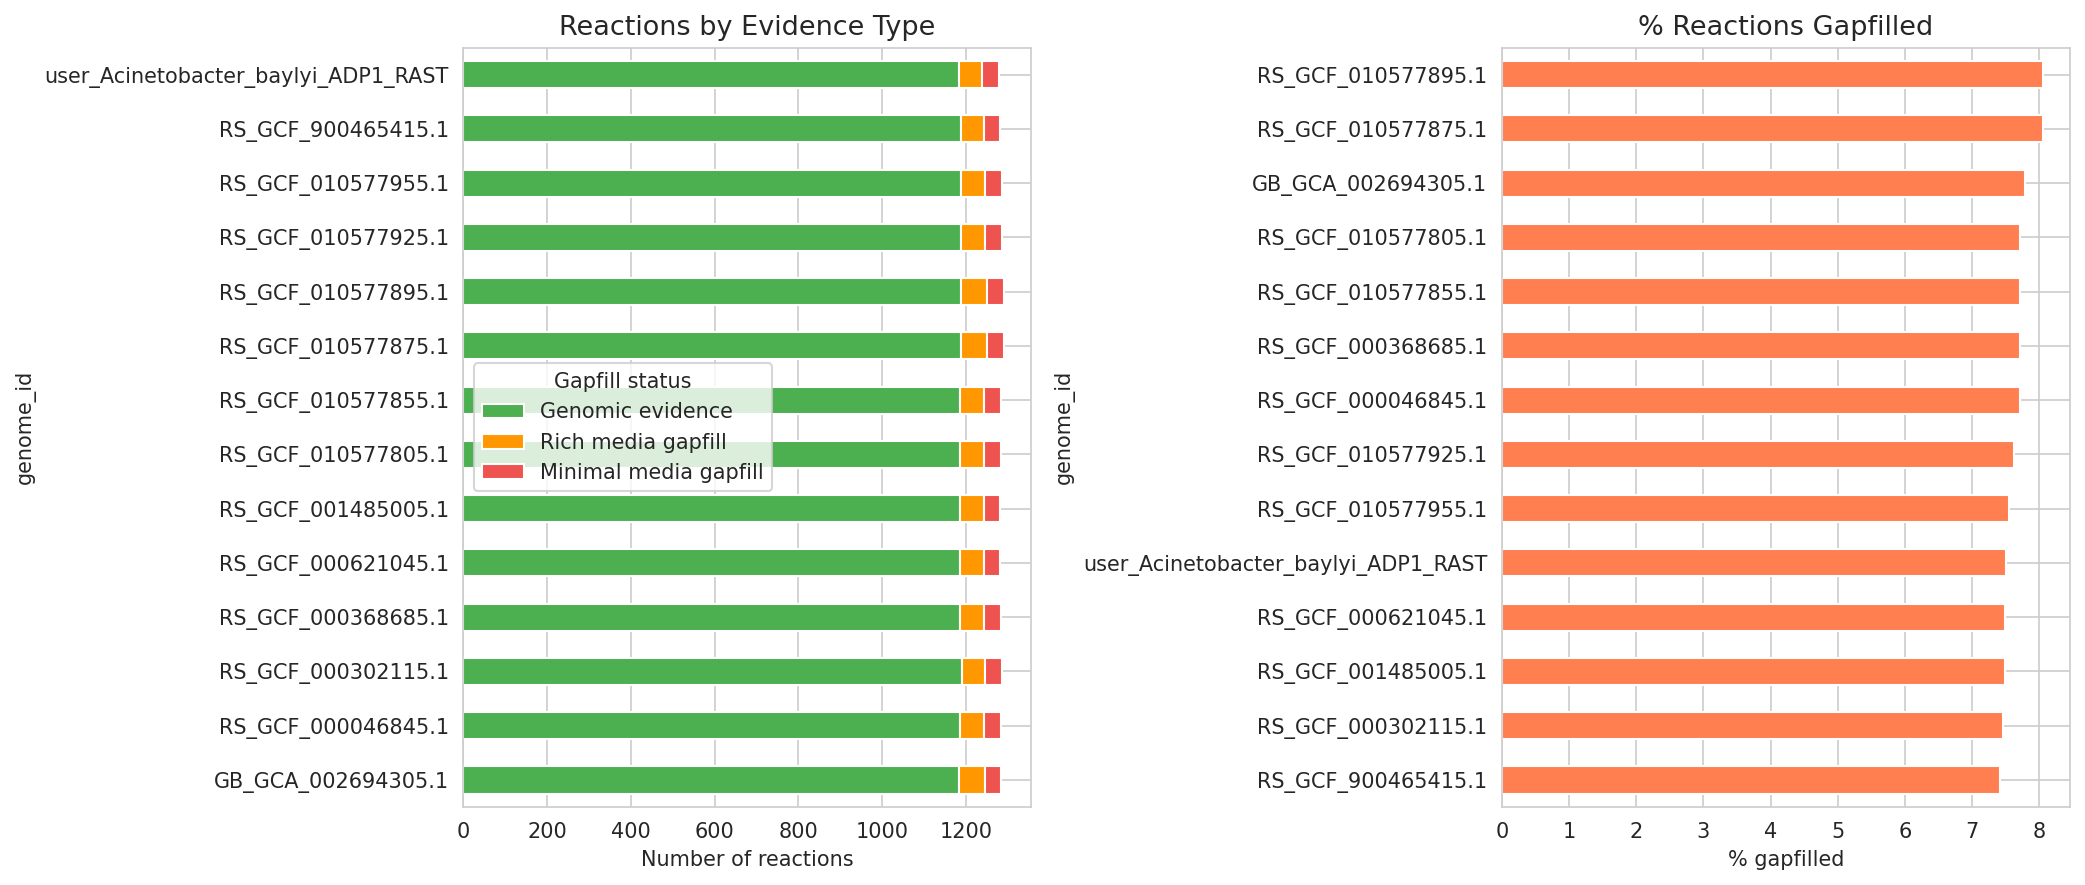

Mean % gapfilled across genomes: 7.7%


In [2]:
# Gapfilling status per genome
gapfill_summary = rxns.groupby(['genome_id', 'gapfilling_status']).size().unstack(fill_value=0)
gapfill_summary['total'] = gapfill_summary.sum(axis=1)
gapfill_summary['pct_gapfilled'] = ((gapfill_summary.get('rich', 0) + gapfill_summary.get('minimal', 0)) 
                                     / gapfill_summary['total'] * 100)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Panel 1: Stacked bar of gapfilling per genome
plot_cols = [c for c in ['none', 'rich', 'minimal'] if c in gapfill_summary.columns]
colors = {'none': '#4CAF50', 'rich': '#FF9800', 'minimal': '#EF5350'}
gapfill_summary[plot_cols].plot(kind='barh', stacked=True, ax=axes[0],
    color=[colors[c] for c in plot_cols])
axes[0].set_title('Reactions by Evidence Type', fontsize=13)
axes[0].set_xlabel('Number of reactions')
axes[0].legend(title='Gapfill status', labels=['Genomic evidence', 'Rich media gapfill', 'Minimal media gapfill'])

# Panel 2: % gapfilled per genome
gapfill_summary.sort_values('pct_gapfilled').plot(
    y='pct_gapfilled', kind='barh', ax=axes[1], color='coral', legend=False)
axes[1].set_title('% Reactions Gapfilled', fontsize=13)
axes[1].set_xlabel('% gapfilled')

plt.tight_layout()
plt.savefig('../figures/reaction_gapfilling.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'Mean % gapfilled across genomes: {gapfill_summary["pct_gapfilled"].mean():.1f}%')

## 2. Reaction Conservation Across Genomes

Which reactions are shared across all 14 genomes, and which are unique?

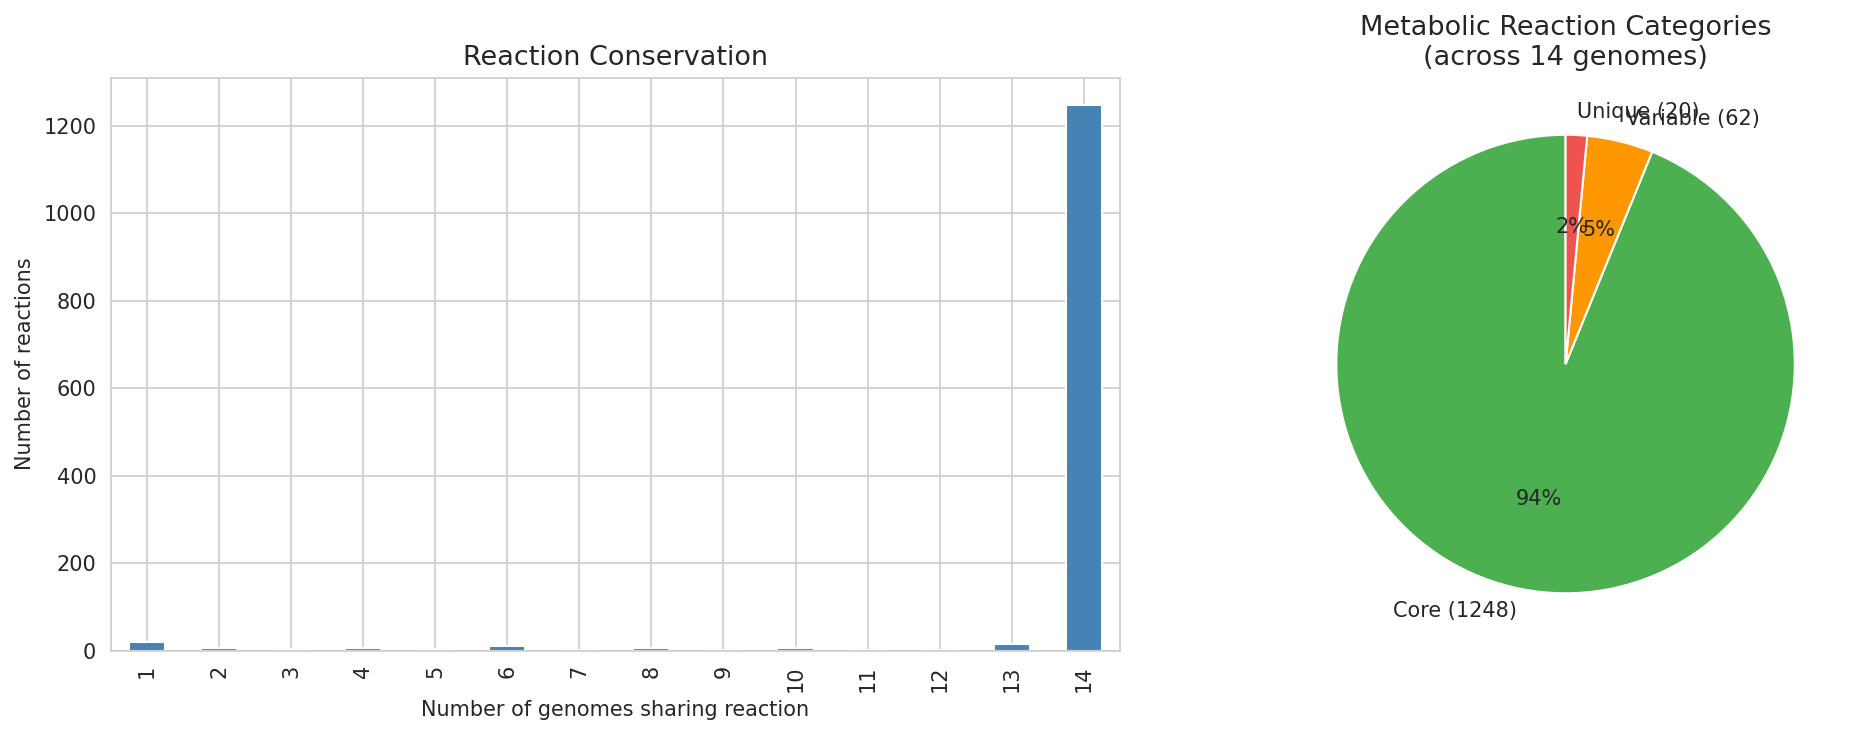

Total unique reactions: 1330
Core (all 14): 1248
Variable (2-13): 62
Unique (1 genome): 20


In [3]:
# Reaction presence matrix
rxn_presence = rxns.groupby(['reaction_id', 'genome_id']).size().unstack(fill_value=0)
rxn_presence = (rxn_presence > 0).astype(int)
rxn_count = rxn_presence.sum(axis=1)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Panel 1: Distribution of reactions by genome count
rxn_count.value_counts().sort_index().plot(kind='bar', ax=axes[0], color='steelblue')
axes[0].set_title('Reaction Conservation', fontsize=13)
axes[0].set_xlabel('Number of genomes sharing reaction')
axes[0].set_ylabel('Number of reactions')

# Panel 2: Core vs variable reactions
n_genomes = rxn_presence.shape[1]
core = (rxn_count == n_genomes).sum()
variable = (rxn_count < n_genomes).sum()
unique = (rxn_count == 1).sum()
axes[1].pie([core, variable - unique, unique],
             labels=[f'Core ({core})', f'Variable ({variable - unique})', f'Unique ({unique})'],
             colors=['#4CAF50', '#FF9800', '#EF5350'],
             autopct='%1.0f%%', startangle=90)
axes[1].set_title(f'Metabolic Reaction Categories\n(across {n_genomes} genomes)', fontsize=13)

plt.tight_layout()
plt.savefig('../figures/reaction_conservation.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'Total unique reactions: {len(rxn_count)}')
print(f'Core (all {n_genomes}): {core}')
print(f'Variable (2-{n_genomes-1}): {variable - unique}')
print(f'Unique (1 genome): {unique}')

## 3. Growth Phenotype Predictions

FBA-predicted growth vs observed growth across compounds.

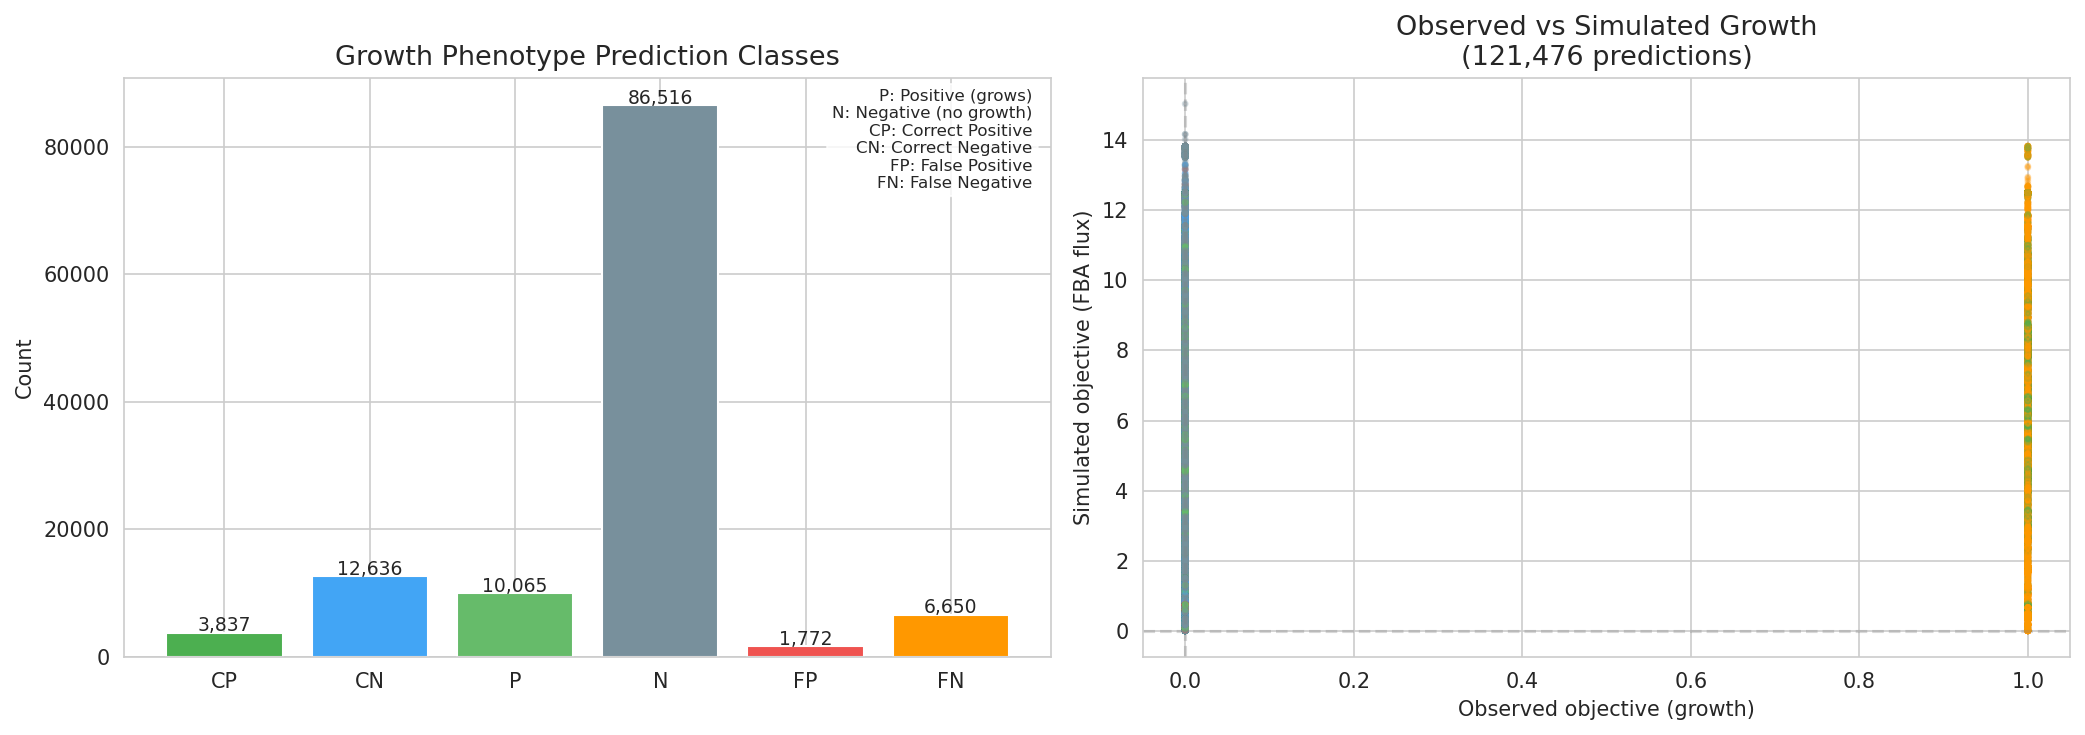

In [4]:
# Prediction class distribution
class_counts = growth_det['class'].value_counts()
class_labels = {
    'P': 'Positive (grows)',
    'N': 'Negative (no growth)',
    'CP': 'Correct Positive',
    'CN': 'Correct Negative',
    'FP': 'False Positive',
    'FN': 'False Negative',
}

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Panel 1: Prediction class distribution
colors_map = {'P': '#66BB6A', 'N': '#78909C', 'CP': '#4CAF50', 'CN': '#42A5F5',
              'FP': '#EF5350', 'FN': '#FF9800'}
class_order = ['CP', 'CN', 'P', 'N', 'FP', 'FN']
class_counts = class_counts.reindex(class_order)
bars = axes[0].bar(class_counts.index, class_counts.values,
                    color=[colors_map.get(c, 'gray') for c in class_counts.index])
axes[0].set_title('Growth Phenotype Prediction Classes', fontsize=13)
axes[0].set_ylabel('Count')
for bar, val in zip(bars, class_counts.values):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 200,
                f'{val:,}', ha='center', fontsize=9)

# Add legend explaining class codes
legend_text = '\n'.join([f'{k}: {v}' for k, v in class_labels.items()])
axes[0].text(0.98, 0.98, legend_text, transform=axes[0].transAxes,
              fontsize=8, va='top', ha='right',
              bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Panel 2: Simulated vs observed objective for predictions with observed data
has_both = growth_det[growth_det['simulated_objective'].notna() & 
                       growth_det['observed_objective'].notna() &
                       growth_det['class'].isin(colors_map.keys())].copy()
if len(has_both) > 0:
    scatter_colors = [colors_map[c] for c in has_both['class']]
    axes[1].scatter(has_both['observed_objective'], has_both['simulated_objective'],
                     alpha=0.3, s=5, c=scatter_colors)
    axes[1].set_xlabel('Observed objective (growth)')
    axes[1].set_ylabel('Simulated objective (FBA flux)')
    axes[1].set_title(f'Observed vs Simulated Growth\n({len(has_both):,} predictions)', fontsize=13)
    axes[1].axhline(y=0, color='gray', linestyle='--', alpha=0.3)
    axes[1].axvline(x=0, color='gray', linestyle='--', alpha=0.3)
else:
    axes[1].text(0.5, 0.5, 'No observed objective data', transform=axes[1].transAxes, ha='center')

plt.tight_layout()
plt.savefig('../figures/growth_phenotype_predictions.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. Gapfilling Impact

How many growth phenotypes require gapfilled reactions?

Phenotype predictions without gapfilling: 16,143 (13%)
Phenotype predictions requiring gapfilling: 105,376 (87%)


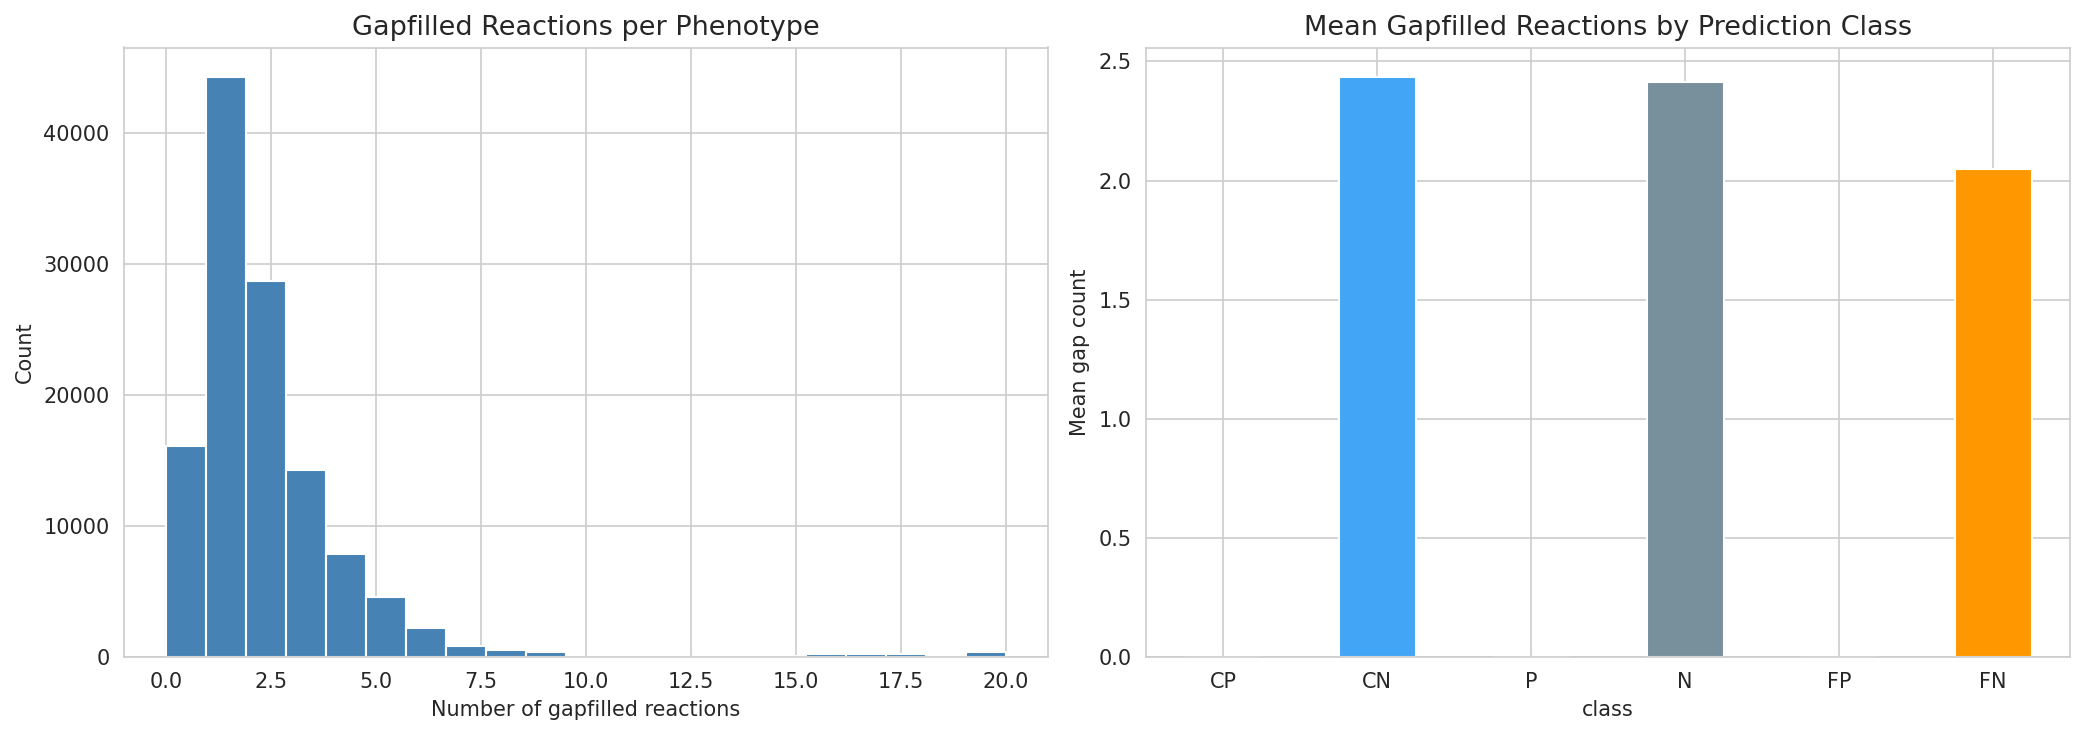

In [5]:
# Gap count distribution
gap_data = growth_det[growth_det['gap_count'].notna()].copy()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Panel 1: Gap count distribution
gap_data['gap_count'].clip(upper=20).hist(bins=21, ax=axes[0], color='steelblue', edgecolor='white')
axes[0].set_title('Gapfilled Reactions per Phenotype', fontsize=13)
axes[0].set_xlabel('Number of gapfilled reactions')
axes[0].set_ylabel('Count')

no_gaps = (gap_data['gap_count'] == 0).sum()
with_gaps = (gap_data['gap_count'] > 0).sum()
print(f'Phenotype predictions without gapfilling: {no_gaps:,} ({no_gaps/len(gap_data)*100:.0f}%)')
print(f'Phenotype predictions requiring gapfilling: {with_gaps:,} ({with_gaps/len(gap_data)*100:.0f}%)')

# Panel 2: Gap count vs prediction class
gap_by_class = gap_data.groupby('class')['gap_count'].mean()
gap_by_class = gap_by_class.reindex(class_order)
gap_by_class.plot(kind='bar', ax=axes[1], color=[colors_map.get(c, 'gray') for c in gap_by_class.index])
axes[1].set_title('Mean Gapfilled Reactions by Prediction Class', fontsize=13)
axes[1].set_ylabel('Mean gap count')
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.savefig('../figures/gapfilling_impact.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Missing Functions

What functions are missing and had to be gapfilled?

In [6]:
print(f'Missing functions (gapfilled): {len(missing)}')
print(f'\nGapfill categories:')
for col in ['RichGapfill', 'MinimalGapfill', 'PhenotypeGapfill', 'ModuleGapfill', 'Pangenome']:
    if col in missing.columns:
        non_null = missing[col].notna().sum()
        print(f'  {col}: {non_null} reactions ({non_null/len(missing)*100:.0f}%)')

print(f'\nSample missing functions:')
display(missing[['Reaction', 'RAST_function']].head(15))

Missing functions (gapfilled): 243

Gapfill categories:
  RichGapfill: 243 reactions (100%)
  MinimalGapfill: 243 reactions (100%)
  PhenotypeGapfill: 243 reactions (100%)
  ModuleGapfill: 243 reactions (100%)
  Pangenome: 243 reactions (100%)

Sample missing functions:


,Reaction,RAST_function
0,rxn05469,Pyruvate [e0] + H+ [e0] <=> Pyruvate [c0] + H+...
1,rxn05064,2 H+ [c0] + Carbamate [c0] --> CO2 [c0] + NH3 ...
2,rxn02374,L-Glutamate5-semialdehyde [c0] --> H2O [c0] + ...
3,rxn05319,H2O [e0] <=> H2O [c0]
4,rxn05730,H+ [e0] + Tetrathionate [e0] <=> H+ [c0] + Tet...
5,rxn04457,"5-Hydroxy-2-oxo-4-ureido-2,5-dihydro-1H-imidaz..."
6,rxn05129,Phosphocreatine [c0] --> Phosphate [c0] + Crea...
7,rxn02916,2-Oxo-6-aminocaproate [c0] --> H2O [c0] + H+ [...
8,rxn05488,Acetate [e0] + H+ [e0] <=> Acetate [c0] + H+ [c0]
9,rxn03012,L-2-Amino-6-oxopimelate [c0] --> H2O [c0] + H+...


## 6. Functional Enrichment in Essential Genes

What COG categories and KEGG pathways are over-represented among essential genes?

Essential genes with KO: 318 / 346
Dispensable genes with KO: 1379 / 2607

Essential genes with COG: 115 (33%)
Dispensable genes with COG: 141 (5%)


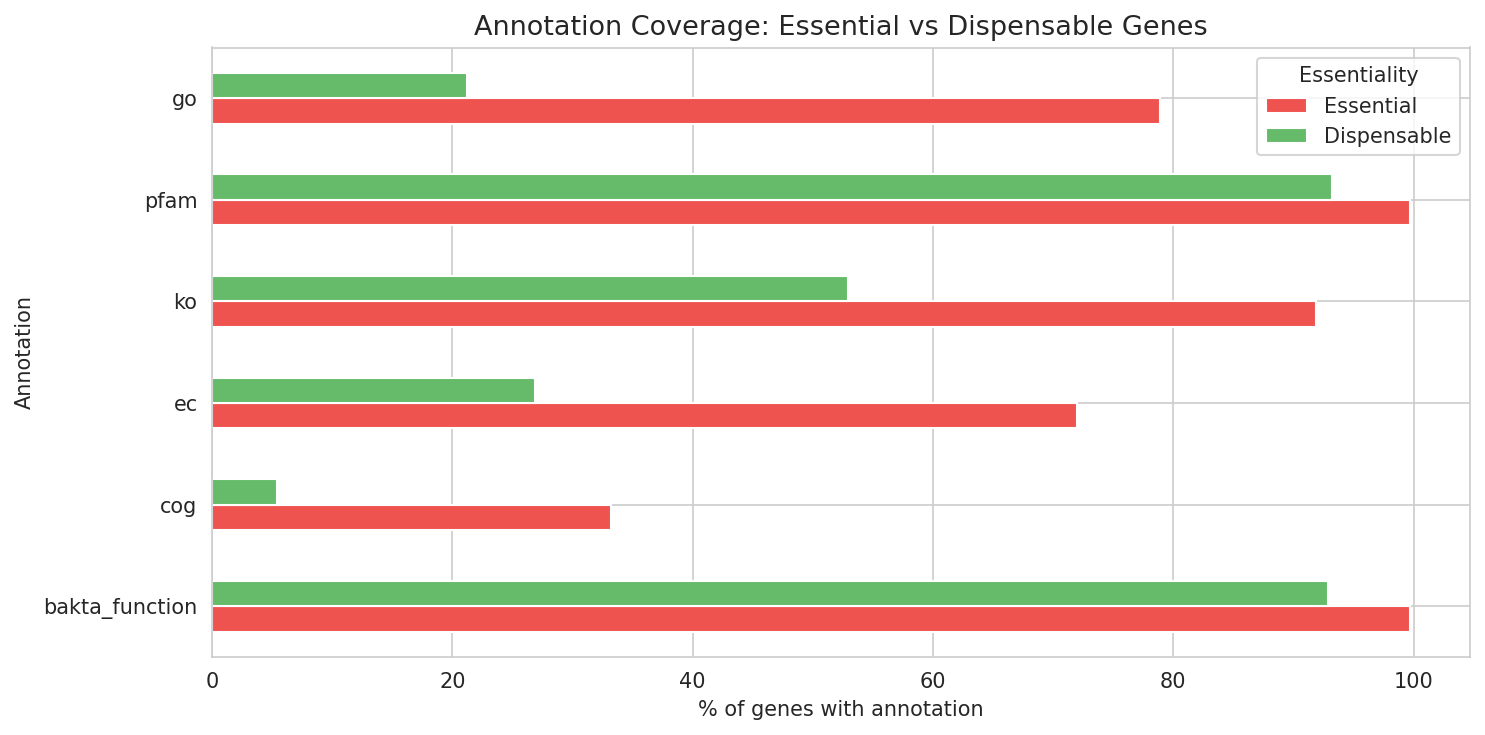

In [7]:
# COG category distribution: essential vs dispensable
ess_genes = gf[gf['essentiality_lb'] == 'essential'].copy()
disp_genes = gf[gf['essentiality_lb'] == 'dispensable'].copy()

def count_cog_categories(df):
    """Count individual COG single-letter categories."""
    all_cogs = df['cog'].dropna().tolist()
    # COG IDs like COG0001 — extract category from the ID
    return len(all_cogs)

# Use KO annotations for pathway analysis
ess_ko = ess_genes['ko'].dropna()
disp_ko = disp_genes['ko'].dropna()

print(f'Essential genes with KO: {len(ess_ko)} / {len(ess_genes)}')
print(f'Dispensable genes with KO: {len(disp_ko)} / {len(disp_genes)}')

# Compare COG coverage
ess_cog = ess_genes['cog'].notna().sum()
disp_cog = disp_genes['cog'].notna().sum()
print(f'\nEssential genes with COG: {ess_cog} ({ess_cog/len(ess_genes)*100:.0f}%)')
print(f'Dispensable genes with COG: {disp_cog} ({disp_cog/len(disp_genes)*100:.0f}%)')

# Compare annotation richness
ann_cols = ['bakta_function', 'cog', 'ec', 'ko', 'pfam', 'go']
fig, ax = plt.subplots(figsize=(10, 5))
ann_data = []
for col in ann_cols:
    ess_pct = ess_genes[col].notna().mean() * 100
    disp_pct = disp_genes[col].notna().mean() * 100
    ann_data.append({'Annotation': col, 'Essential': ess_pct, 'Dispensable': disp_pct})

ann_df = pd.DataFrame(ann_data).set_index('Annotation')
ann_df.plot(kind='barh', ax=ax, color=['#EF5350', '#66BB6A'])
ax.set_title('Annotation Coverage: Essential vs Dispensable Genes', fontsize=13)
ax.set_xlabel('% of genes with annotation')
ax.legend(title='Essentiality')
plt.tight_layout()
plt.savefig('../figures/annotation_by_essentiality.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Ontology Overview

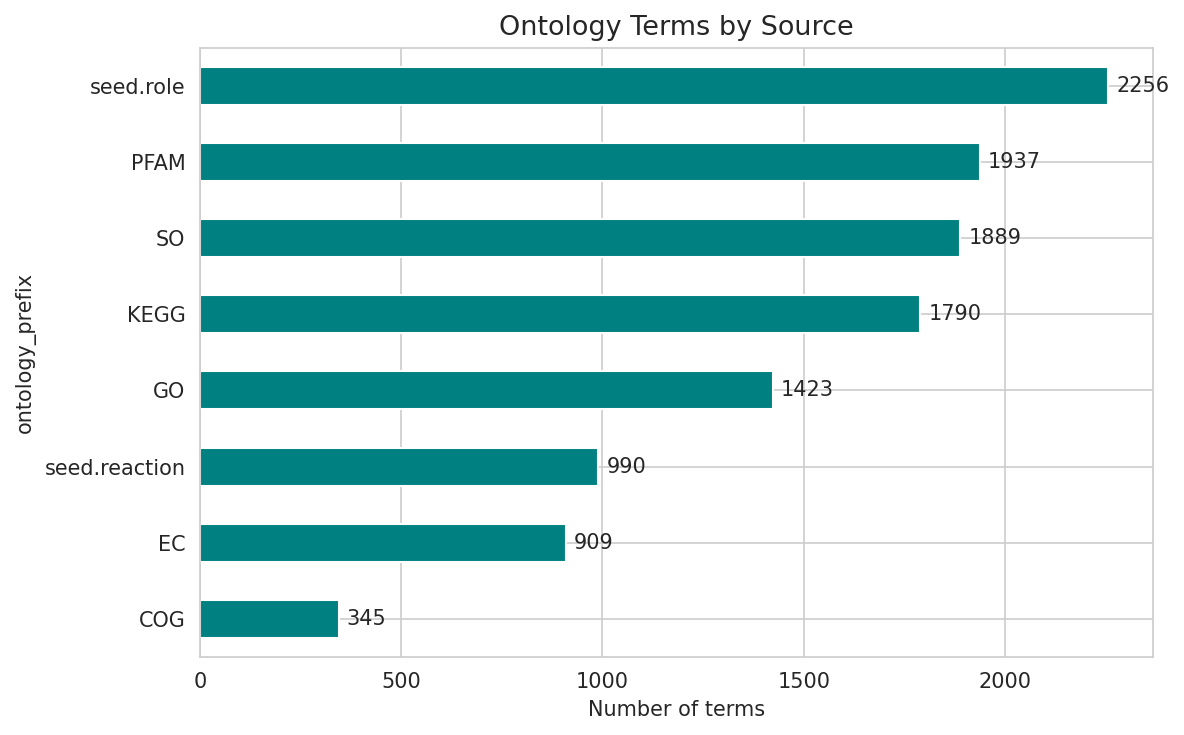

Total ontology terms: 11539


In [8]:
# Ontology term distribution
ont_terms = pd.read_sql('SELECT * FROM ontology_terms', conn)
ont_by_prefix = ont_terms.groupby('ontology_prefix').size().sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(8, 5))
ont_by_prefix.plot(kind='barh', ax=ax, color='teal')
ax.set_title('Ontology Terms by Source', fontsize=13)
ax.set_xlabel('Number of terms')
for i, (val, name) in enumerate(zip(ont_by_prefix.values, ont_by_prefix.index)):
    ax.text(val + 20, i, str(val), va='center', fontsize=10)
plt.tight_layout()
plt.savefig('../figures/ontology_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

conn.close()
print(f'Total ontology terms: {len(ont_terms)}')